Gender: Male
Age: 25-32 years


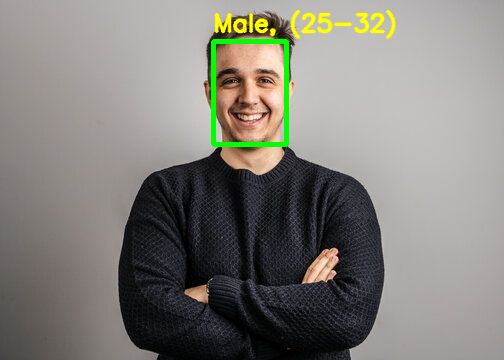

In [8]:
import cv2
from google.colab.patches import cv2_imshow

def highlight_face(net, frame, conf_thresh=0.7):
    frame_height, frame_width = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104, 117, 123], True, False)
    net.setInput(blob)
    detections = net.forward()
    face_boxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_thresh:
            x1 = int(detections[0, 0, i, 3] * frame_width)
            y1 = int(detections[0, 0, i, 4] * frame_height)
            x2 = int(detections[0, 0, i, 5] * frame_width)
            y2 = int(detections[0, 0, i, 6] * frame_height)
            face_boxes.append([x1, y1, x2, y2])
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), max(frame_height, frame_width) // 150, 8)
    return frame, face_boxes

def main():
    image_path = "/content/test_image.jpg"  # Change the path to your image
    face_proto = "/content/opencv_face_detector.pbtxt"
    face_model = "/content/opencv_face_detector_uint8.pb"
    age_proto = "/content/age_deploy.prototxt"
    age_model = "/content/age_net.caffemodel"
    gender_proto = "/content/gender_deploy.prototxt"
    gender_model = "/content/gender_net.caffemodel"

    model_mean_values = (78.4263377603, 87.7689143744, 114.895847746)
    age_list = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
    gender_list = ['Male', 'Female']

    face_net = cv2.dnn.readNet(face_model, face_proto)
    age_net = cv2.dnn.readNet(age_model, age_proto)
    gender_net = cv2.dnn.readNet(gender_model, gender_proto)

    video = cv2.VideoCapture(image_path)
    padding = 20

    while cv2.waitKey(1) < 0:
        has_frame, frame = video.read()
        if not has_frame:
            cv2.waitKey()
            break

        result_img, face_boxes = highlight_face(face_net, frame)
        if not face_boxes:
            print("No face detected")
            continue

        for face_box in face_boxes:
            face = frame[max(0, face_box[1] - padding): min(face_box[3] + padding, frame.shape[0] - 1),
                   max(0, face_box[0] - padding): min(face_box[2] + padding, frame.shape[1] - 1)]

            blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), model_mean_values, swapRB=False)
            gender_net.setInput(blob)
            gender_preds = gender_net.forward()
            gender = gender_list[gender_preds[0].argmax()]
            print(f'Gender: {gender}')

            age_net.setInput(blob)
            age_preds = age_net.forward()
            age = age_list[age_preds[0].argmax()]
            print(f'Age: {age[1:-1]} years')

            cv2.putText(result_img, f'{gender}, {age}', (face_box[0], face_box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.8, (0, 255, 255), 2, cv2.LINE_AA)
        cv2_imshow( result_img)

    video.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()
